In [1]:
import os
import math
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import tensorflow as tf

import keras.backend.tensorflow_backend as K
from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, Input, merge, Flatten, Lambda, concatenate, Bidirectional, LSTM, Reshape
from keras.optimizers import SGD,Adam, Adadelta
from keras.models import load_model

from tqdm import tqdm

Using TensorFlow backend.


In [13]:
def create_model():
    input_layer = Input(shape=(10,4))

    output = LSTM(4, return_sequences=False)(input_layer)

    output = Dense(2, activation="softmax")(output)

    model = Model(inputs=input_layer, outputs=output)

    optimizer = Adam(0.001) 
    model.compile(loss='categorical_crossentropy', optimizer=optimizer)
    return model

def retrain(training_set, target):
    model = create_model()
    
    model.fit(np.array(training_set), np.array(target), epochs=200, validation_split=0.2, verbose=2)
    print("Retraining....")
    
    return model


def load_lstm(part_idx, currency_pair):
    model_path = "model_final_retrain/lstm_retrain_200_"+str(currency_pair)+str(part_idx)+".h5"
    model = load_model(model_path)
    return model

In [27]:
def init_params(testing_hourly, backtest_params):
    params = {
        "currency_pair":backtest_params["currency_pair"],
        
        "balance":1000,
        "volume": backtest_params["volume"]*10000, #10,000 == 1 lot
        "tp": backtest_params["tp"], # 400 pips
        "sl": backtest_params["sl"], # 400 pips

        "hour_counter":0,
        "day_count":0,
        "today_positions":[],
        "model_inputs":[[0,0,0,0]],

        "polarity":0,
        "tp_boundary":0,
        "sl_boundary":0,
        
        "latest_date":testing_hourly["<DATE>"][0],
        "minimum_training_set":1411,
        "is_retrain":backtest_params["is_retrain"],
        "retrain_interval":200
    }
    return params

def close_order(order):
    order["open_position"]=None
    order["age"] = 0
    order["type"] = None
    order["tp_pos"] = None
    order["sl_pos"] = None
    order["close_status"] = None
    order["opening_time"] = None
    order["closing_time"] = None

def is_there_an_order(order):
    if(order["open_position"]!=None):
        return True
    return False

def order_aging(order):
    if(is_there_an_order(order)):
        order["age"]+=1

def calculateMargin(open_position, close_position, order_type, order_volume):
    if (order_type == "BUY"):
        return (close_position - open_position) * order_volume
    elif(order_type == "SELL"):
        return (open_position - close_position) * order_volume
    return 0

def hourly_to_daily(today_positions):
    today_open = today_positions[0][0]
    today_high = np.max(today_positions) 
    today_low = np.min(today_positions)
    today_close = today_positions[-1][3]
    return [today_open, today_high, today_low, today_close]

def update(params, record):
    if(record["<DATE>"] != params["latest_date"]):
        params["day_count"] += 1
        params["hour_counter"] = 0
        params["model_inputs"].append(hourly_to_daily(params["today_positions"]))
        params["today_positions"] = []
        
    params["today_positions"].append([record["<OPEN>"], record["<HIGH>"], record["<LOW>"], record["<CLOSE>"]])
    params["hour_counter"]+=1

        
def scale_diff(next_val, curr_val):
    scaled_diff = min(1, next_val-curr_val)
    scaled_diff = max(-1, scaled_diff)
    return scaled_diff

def find_diff(model_inputs):
    diff_model_inputs = []
    for i in range(len(model_inputs[:-1])):
        curr_record = model_inputs[i]
        next_record = model_inputs[i+1]
        
        open_diff = scale_diff(next_record[0], curr_record[0])
        high_diff = scale_diff(next_record[1], curr_record[1])
        low_diff = scale_diff(next_record[2], curr_record[2])
        close_diff = scale_diff(next_record[3], curr_record[3])
        
        diff_model_inputs.append([open_diff,high_diff,low_diff,close_diff])
    return diff_model_inputs


def update_volume(balance, avg_swing, static_scale):
    return ((balance * 0.1) / avg_swing) * static_scale

def update_model_inputs(diff_model_inputs, retrain_input, retrain_target):
    if(len(retrain_input) >= 1401):
        del retrain_input[:1]
        
    retrain_input.append(diff_model_inputs)
    
    if(len(retrain_input) > 1):
        if(len(retrain_target) >= 1400):
            del retrain_target[:1]
        retrain_target.append(find_target_for_retrain(diff_model_inputs[-1]))

def find_target_for_retrain(diff_model_input):    
    if(diff_model_input[1] >= -1*diff_model_input[2]):
        return [0,1]
    else:
        return [1,0]
        
def ask_model_for_signal(model, params, record, order_signal, retrain_input, retrain_target):
    diff_model_inputs = find_diff(params["model_inputs"])
    if(len(params["model_inputs"])>=11 and params["day_count"] >= params["minimum_training_set"]):
        if(params["day_count"] >= params["minimum_training_set"] and (params["day_count"]-11) % params["retrain_interval"] == 0 ):
            if(params["is_retrain"] == "always"):
                part_idx = int((params["day_count"] - params["minimum_training_set"])/200)
                print(record)
                model = load_lstm(part_idx, params["currency_pair"])
            elif(params["is_retrain"] == "once"):
                model = load_lstm(0, params["currency_pair"])
                params["is_retrain"] = "trained"
        
        order_signal = model.predict(np.expand_dims(np.array(diff_model_inputs), axis=0))[0]
        params["model_inputs"] = params["model_inputs"][1:]

        update_model_inputs(diff_model_inputs, retrain_input, retrain_target)
        
        

    elif(len(params["model_inputs"])>=11):
        params["latest_date"] = record["<DATE>"]
        params["model_inputs"] = params["model_inputs"][1:]
        
        update_model_inputs(diff_model_inputs, retrain_input, retrain_target)
    else:
        params["latest_date"] = record["<DATE>"]

    return order_signal, model
    
def should_order_be_closed(order, params, record, order_history):
    close_order_event = {}
    if(order["type"]=="BUY"):
        params["polarity"] = 1
        params["tp_boundary"] = record["<HIGH>"]
        params["sl_boundary"] = record["<LOW>"]
    elif(order["type"]=="SELL"):
        params["polarity"] = -1
        params["tp_boundary"] = record["<LOW>"]
        params["sl_boundary"] = record["<HIGH>"]
        
    if(is_there_an_order(order)):
        profit = 0
        closing_position = 0
        if(params["sl_boundary"]*params["polarity"] <= order["sl_pos"]*params["polarity"]):
            profit = calculateMargin(order["open_position"], order["sl_pos"], order["type"], params["volume"])
            params["balance"] += profit
            order["close_status"] = "sl"
            order["closing_time"] = record["<DATE>"]+"-"+record["<TIME>"]
            closing_position = order["sl_pos"]
        elif(params["tp_boundary"]*params["polarity"] >= order["tp_pos"]*params["polarity"]):
            profit = calculateMargin(order["open_position"], order["tp_pos"], order["type"], params["volume"])
            params["balance"] += profit
            order["close_status"] = "tp"
            order["closing_time"] = record["<DATE>"]+"-"+record["<TIME>"]
            closing_position = order["tp_pos"]
        # In case neither sl or tp is reached, the order will be closed at the end of the day
        elif (record["<DATE>"] != params["latest_date"]):
            profit =  calculateMargin(order["open_position"], record["<OPEN>"], order["type"], params["volume"])
            params["balance"] += profit
            order["close_status"] = "eotd"
            order["closing_time"] = record["<DATE>"]+"-"+record["<TIME>"]
            closing_position = record["<CLOSE>"]
            
        if(not order["close_status"] is None):
            order_history.append(order.copy())
            close_order(order)
            
            close_order_event = {
                "closing_position":closing_position,
                "profit":profit,
                "datetime":record["<DATE>"]
            }
    return close_order_event


In [28]:
def evaluate(testing_hourly, model, backtest_params):
    order = {
        "open_position":None,
        "age":0,
        "type":None,
        "tp_pos":None,
        "sl_pos":None,
        "close_status":None,
        "opening_time":None,
        "closing_time":None
    }
    
    params = init_params(testing_hourly, backtest_params)
    
    balance_history = [params["balance"]]
    order_history = []
    order_signal = None
    
    retrain_input = []
    retrain_target = []
    
    open_order_events = []
    close_order_events = []
    
    
    
    for idx, record in tqdm(testing_hourly[:-1].iterrows()):
        
        open_order_event = {}
        close_order_event = {}
    
        # Update params hourly
        update(params, record)

        # Call the model for a signal
        order_signal, model = ask_model_for_signal(model, params, record, order_signal, retrain_input, retrain_target)

        # Check whether sl or tp is reached
        close_order_event = should_order_be_closed(order, params, record, order_history)

        # Open an order
        if(not order_signal is None):
            if ((not is_there_an_order(order)) and (record["<DATE>"] != params["latest_date"])):
                order["opening_time"] = record["<DATE>"]+"-"+record["<TIME>"]
                order["open_position"] = record["<OPEN>"]       
                # Classification Model Logic
                if(np.argmax(order_signal) == 0):
                    order["type"] = "SELL"
                elif(np.argmax(order_signal) == 1):
                    order["type"] = "BUY"
                else:
                    order["type"] = None

                order["tp_pos"] = order["open_position"]+params["tp"] if order["type"]=="BUY" else order["open_position"]-params["tp"]
                order["sl_pos"] = order["open_position"]-params["sl"] if order["type"]=="BUY" else order["open_position"]+params["sl"]
                
                
                open_order_event = {
                    "open_position":order["open_position"],
                    "order_type":order["type"],
                    "volume":params["volume"],
                    "datetime":record["<DATE>"]
                }
                
            params["latest_date"] = record["<DATE>"]
        
        balance_history.append(params["balance"])

        # Let the order ages
        order_aging(order)
        
        open_order_events.append(open_order_event)
        close_order_events.append(close_order_event)
    
    open_order_events.append({})
    close_order_events.append({})
    
    graph = pd.DataFrame({
        "date":testing_hourly["<DATE>"],
        "open":testing_hourly["<OPEN>"],
        "high":testing_hourly["<HIGH>"],
        "low":testing_hourly["<LOW>"],
        "close":testing_hourly["<CLOSE>"],
        "volume":testing_hourly["<TICKVOL>"],
        "balance_history":balance_history,
        "open_order_events":open_order_events,
        "close_order_events":close_order_events
    })
    K.clear_session()

    return graph.to_dict('records')

In [29]:
def backtest(currency_pair, is_retrain, volume, sl, tp):
    backtest_params = {
        "currency_pair":currency_pair,
        "is_retrain": "always" if(is_retrain) else "once",
        "volume":volume,
        "sl":sl,
        "tp":tp
    }

    num_step = 10
    skip_step = 1
    test_range_limit = 200

    file_path = "oneshot_dataset/"+currency_pair+"_H1_200910290000_201901252300.csv"
    testing_hourly = pd.read_csv(file_path, sep='\t')
    
    if ("JPY" in file_path):
        testing_hourly['<OPEN>'] = testing_hourly['<OPEN>']/100
        testing_hourly['<HIGH>'] = testing_hourly['<HIGH>']/100
        testing_hourly['<LOW>'] = testing_hourly['<LOW>']/100
        testing_hourly['<CLOSE>'] = testing_hourly['<CLOSE>']/100

    graph = evaluate(testing_hourly, create_model(), backtest_params)
    
    return graph

graph = backtest("EURJPY", True, 1, 400, 400)

33315it [00:05, 6445.31it/s]

<DATE>       2015.04.03
<TIME>         00:00:00
<OPEN>          1.30245
<HIGH>           1.3037
<LOW>           1.30245
<CLOSE>         1.30251
<TICKVOL>          1399
<VOL>                 0
<SPREAD>             11
Name: 33545, dtype: object


38133it [00:07, 4930.16it/s]

<DATE>       2016.01.12
<TIME>         00:00:00
<OPEN>          1.27868
<HIGH>          1.27968
<LOW>           1.27795
<CLOSE>         1.27853
<TICKVOL>          5248
<VOL>        3533450000
<SPREAD>              9
Name: 38333, dtype: object


43107it [00:10, 4085.34it/s]

<DATE>       2016.10.18
<TIME>         00:00:00
<OPEN>          1.14233
<HIGH>          1.14307
<LOW>           1.14182
<CLOSE>          1.1425
<TICKVOL>          2451
<VOL>        1056074000
<SPREAD>              0
Name: 43130, dtype: object


47773it [00:13, 3521.05it/s]

<DATE>       2017.07.25
<TIME>         00:00:00
<OPEN>          1.29348
<HIGH>          1.29412
<LOW>           1.29298
<CLOSE>         1.29367
<TICKVOL>          7326
<VOL>                 0
<SPREAD>             15
Name: 47921, dtype: object


52322it [00:16, 3120.90it/s]

<DATE>       2018.05.03
<TIME>         00:00:00
<OPEN>          1.31303
<HIGH>          1.31364
<LOW>           1.31238
<CLOSE>          1.3134
<TICKVOL>          3973
<VOL>                 0
<SPREAD>              1
Name: 52713, dtype: object


57256it [00:20, 2797.45it/s]


3319.8000000000256


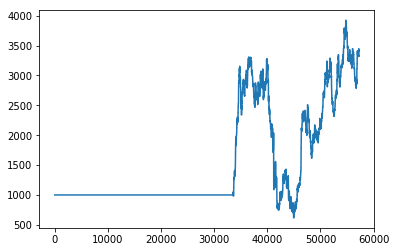

In [26]:
print(graph[-1]["balance_history"])
balance_hist = []
for i in graph:
    balance_hist.append(i["balance_history"])
plt.plot(balance_hist)